modify from the analysis folder, have not tested.

In [13]:
import os
from collections import defaultdict
import pandas as pd

import pandas as pd
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point

from pyonemap import OneMap
#from decouple import config
from decouple import AutoConfig
config = AutoConfig(search_path='./')

#import matplotlib.pyplot as plt
#import seaborn as sns

from tqdm import tqdm

In [9]:
recent_file =  'raw_data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards-2024-0515.csv'

fp = os.path.join(recent_file)
df = pd.read_csv(fp)
#print(df.head())
df = df[['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
         'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']]
df['resale_year'] = [int(m[0]) for m in df['month'].str.split('-')]
df['resale_month'] = [int(m[1]) for m in df['month'].str.split('-')]
df['resale_age'] = df['resale_year'] - df['lease_commence_date']
df['floor_area_sqft'] = df['floor_area_sqm']*10.764
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_year,resale_month,resale_age,floor_area_sqft
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,2017,1,38,473.616
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,250000.0,2017,1,39,721.188
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,262000.0,2017,1,37,721.188
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,265000.0,2017,1,37,731.952
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,265000.0,2017,1,37,721.188


In [10]:
year = 2024
outdir = '../data_base/hdb/yearly/'
df_yr = df[df['resale_year']==year]
print(year, len(df_yr))
#out_fp = os.path.join(outdir, 'data_{}.csv.xz'.format(year))
#df_yr.to_csv(out_fp)

2024 10184


In [11]:
df_yr.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_year,resale_month,resale_age,floor_area_sqft
169156,2024-01,ANG MO KIO,2 ROOM,116,ANG MO KIO AVE 4,07 TO 09,44.0,Improved,1978,288000.0,2024,1,46,473.616
169157,2024-01,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,04 TO 06,44.0,Improved,1980,322500.0,2024,1,44,473.616
169158,2024-01,ANG MO KIO,3 ROOM,308B,ANG MO KIO AVE 1,01 TO 03,70.0,Model A,2012,520000.0,2024,1,12,753.480
169159,2024-01,ANG MO KIO,3 ROOM,308B,ANG MO KIO AVE 1,25 TO 27,70.0,Model A,2012,650000.0,2024,1,12,753.480
169160,2024-01,ANG MO KIO,3 ROOM,223,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1978,343800.0,2024,1,46,721.188


In [14]:
onemap = OneMap(config('TOKEN'))

In [15]:
unique_addresses = set()
total_len = 0
tmp1 = df_yr
tmp1 = tmp1.reset_index(drop=True)
#print(tmp1)
#print(len(tmp1))
total_len+=len(tmp1)
adds = []
for b, s in zip(tmp1['block'], tmp1['street_name']):
    a0 = '{} {}'.format(b, s)
    adds.append(a0)
adds = set(adds)
unique_addresses = unique_addresses.union(adds)
print(len(unique_addresses), total_len)

5485 10184


In [17]:
previous_file = "geocoded/hdb_geocode.shp"
geocoded_long = gpd.read_file(previous_file)
geocoded_long.head()

,ADDRESS,LAT,LNG,X,Y,POSTAL,geometry
0,684D CHOA CHU KANG CRES,1.404678,103.746800,18371.674144,42947.873063,684684,POINT (18371.674 42947.873)
1,285 BT BATOK EAST AVE 3,1.346175,103.757832,19599.217406,36478.834199,650285,POINT (19599.217 36478.834)
2,225A COMPASSVALE WALK,1.387650,103.898706,35276.790895,41064.875160,541225,POINT (35276.791 41064.875)
3,14 TAMAN HO SWEE,1.287905,103.832198,27875.255897,30035.468577,161014,POINT (27875.256 30035.469)
4,868B TAMPINES AVE 8,1.355924,103.932912,39083.651808,37556.966037,522868,POINT (39083.652 37556.966)


In [18]:
prev_geocoded = geocoded_long['ADDRESS'].tolist()

got_prev_results = {}
no_data = []
for a in unique_addresses:
    if a in prev_geocoded:
        got_prev_results[a] = prev_geocoded.index(a)
    else:
        no_data.append(a)
len(got_prev_results), len(no_data)

(5485, 0)

In [13]:
nodata_geocoded = {}
for a in tqdm(no_data):
    loc = onemap.search(a)
    nodata_geocoded[a] = loc

100%|██████████| 28/28 [00:03<00:00,  9.24it/s]


In [14]:
for a, res in nodata_geocoded.items():
    if res['found']==1:
        pass
    else:
        print(a, res)

In [15]:
for a, res in nodata_geocoded.items():
    if not(len(res['results'])==1):
        print(a, res)

In [16]:
one_locs = []
pts = []
for a, res in nodata_geocoded.items():
    res = res['results'][0]
    x = float(res['X'])
    y = float(res['Y'])
    this_item = {
        'ADDRESS': a, 
        'LAT': float(res['LATITUDE']), 
        'LNG': float(res['LONGITUDE']), 
        'X': x, 
        'Y': y, 
        'POSTAL': str(res['POSTAL']).zfill(6)
    }
    one_locs.append(this_item)
    pts.append(Point((x, y)))
    #break

one_loc_df = pd.DataFrame.from_dict(one_locs)#.reset_index()
one_loc_gdf = gpd.GeoDataFrame(one_loc_df, geometry=pts, crs='epsg:3414')

In [17]:
geocoded_long2 = pd.concat([geocoded_long, one_loc_gdf])
geocoded_long2

,ADDRESS,LAT,LNG,X,Y,POSTAL,geometry
0,684D CHOA CHU KANG CRES,1.404678,103.746800,18371.674144,42947.873063,684684,POINT (18371.674 42947.873)
1,285 BT BATOK EAST AVE 3,1.346175,103.757832,19599.217406,36478.834199,650285,POINT (19599.217 36478.834)
2,225A COMPASSVALE WALK,1.387650,103.898706,35276.790895,41064.875160,541225,POINT (35276.791 41064.875)
3,14 TAMAN HO SWEE,1.287905,103.832198,27875.255897,30035.468577,161014,POINT (27875.256 30035.469)
4,868B TAMPINES AVE 8,1.355924,103.932912,39083.651808,37556.966037,522868,POINT (39083.652 37556.966)
...,...,...,...,...,...,...,...
23,25A ST. GEORGE'S LANE,1.321837,103.861839,31174.057596,33787.512931,321025,POINT (31174.058 33787.513)
24,188C BEDOK NTH ST 4,1.331803,103.940786,39960.008853,34889.837333,463188,POINT (39960.009 34889.837)
25,26B ST. GEORGE'S LANE,1.321669,103.862718,31271.853814,33768.937560,322026,POINT (31271.854 33768.938)
26,438B BT BATOK WEST AVE 8,1.357890,103.740481,17668.264514,37774.267671,652438,POINT (17668.265 37774.268)


In [18]:
new_file = "geocoded/hdb_geocode.shp"
geocoded_long2.to_file(new_file)

In [ ]:
# save geocoded to shapefile

In [ ]:
# here start to process the year data to geojson

In [19]:
df_yr2 = df_yr.copy()
df_yr2 = df_yr2.reset_index(drop=True)
adds = []
for b, s in zip(tmp1['block'], tmp1['street_name']):
    a0 = '{} {}'.format(b, s)
    adds.append(a0)
    #print(a0)
df_yr2['ADDRESS'] = adds
print(len(df_yr2))
df_yr2 = df_yr2.merge(geocoded_long2, on='ADDRESS', how='left')
print(len(df_yr2))

10184
10184


In [20]:
gdf_yr2 = gpd.GeoDataFrame(df_yr2, geometry='geometry', crs='epsg:3414')
gdf_yr2.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_year,resale_month,resale_age,ADDRESS,LAT,LNG,X,Y,POSTAL,geometry
0,2024-01,ANG MO KIO,2 ROOM,116,ANG MO KIO AVE 4,07 TO 09,44.0,Improved,1978,288000.0,2024,1,46,116 ANG MO KIO AVE 4,1.373346,103.836459,28349.529081,39483.177631,560116,POINT (28349.529 39483.178)
1,2024-01,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,04 TO 06,44.0,Improved,1980,322500.0,2024,1,44,510 ANG MO KIO AVE 8,1.373401,103.849073,29753.300929,39489.217940,560510,POINT (29753.301 39489.218)
2,2024-01,ANG MO KIO,3 ROOM,308B,ANG MO KIO AVE 1,01 TO 03,70.0,Model A,2012,520000.0,2024,1,12,308B ANG MO KIO AVE 1,1.365266,103.844538,29248.594650,38589.712063,562308,POINT (29248.595 38589.712)
3,2024-01,ANG MO KIO,3 ROOM,308B,ANG MO KIO AVE 1,25 TO 27,70.0,Model A,2012,650000.0,2024,1,12,308B ANG MO KIO AVE 1,1.365266,103.844538,29248.594650,38589.712063,562308,POINT (29248.595 38589.712)
4,2024-01,ANG MO KIO,3 ROOM,223,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1978,343800.0,2024,1,46,223 ANG MO KIO AVE 1,1.366048,103.838123,28534.643227,38676.172861,560223,POINT (28534.643 38676.173)


<Axes: >

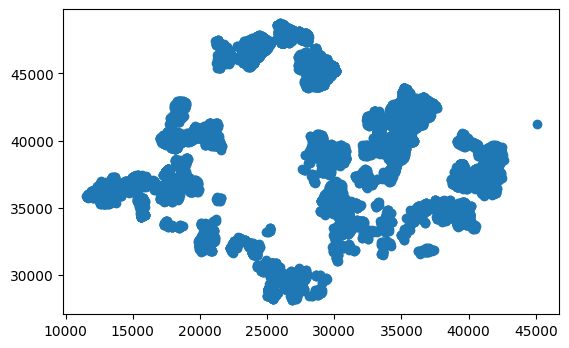

In [23]:
gdf_yr2.plot()

In [24]:
gdf_yr2 = gdf_yr2.to_crs('epsg:4326')  # geojson has to be 4326, for web mapping
gdf_yr2.to_file('geojson/year{}.geojson'.format(year), driver='GeoJSON')